# Profile Functions that construct apps for evaluating the optimization algorithm

* 6 functions
* 2 CPU intensive: f1, f2, f5, f6
* 1 disk IO intensive: f3
* 1 network IO intenstive: f4

In [2]:
import os
import logging
from io import BytesIO
import time
import zipfile
import numpy as np
import boto3
from datetime import datetime, timezone
from time import gmtime, strftime
import json
import pandas as pd
import matplotlib.pyplot as plt
import math

In [3]:
import pickle

In [4]:
import matplotlib.pyplot as plt

In [5]:
client = boto3.client('lambda')

In [6]:
function_prefix='OptAlg'

In [7]:
function_count = 6

In [8]:
# The difference between UTC and local timezone
timezone_offset = 0

## Create Functions

### Function Name List

In [9]:
function_name_list = [function_prefix+'_f'+str(i) for i in range(1, function_count+1)]
print(function_name_list)

['OptAlg_f1', 'OptAlg_f2', 'OptAlg_f3', 'OptAlg_f4', 'OptAlg_f5', 'OptAlg_f6']


### Send Requests to Create Lambda Functions

In [10]:
function_creation_response = []
for function in function_name_list:
    response = client.create_function(
        FunctionName=function,
        Runtime='python3.7',
        Role='arn:aws:iam::499537426559:role/ServerlessAppPerfOpt',
        Handler='lambda_function.lambda_handler',
        Code={
            'ZipFile': b"PK\x03\x04\x14\x00\x00\x00\x00\x00\xf3s;P\x84\xf0r\x96Z\x00\x00\x00Z\x00\x00\x00\x12\x00\x00\x00lambda_function.pydef lambda_handler(event, context):\n    pass\n    return {\n        'statusCode': 200\n    }\nPK\x03\x04\x14\x00\x00\x00\x00\x00\x05q;P\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x13\x00\x00\x00.ipynb_checkpoints/PK\x01\x02\x14\x03\x14\x00\x00\x00\x00\x00\xf3s;P\x84\xf0r\x96Z\x00\x00\x00Z\x00\x00\x00\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb4\x81\x00\x00\x00\x00lambda_function.pyPK\x01\x02\x14\x03\x14\x00\x00\x00\x00\x00\x05q;P\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\xfdA\x8a\x00\x00\x00.ipynb_checkpoints/PK\x05\x06\x00\x00\x00\x00\x02\x00\x02\x00\x81\x00\x00\x00\xbb\x00\x00\x00\x00\x00"
        },
        Description='Analytical Model Evaluation {}'.format(function),
        Timeout=60,
        MemorySize=128
    )
    function_creation_response.append(response)
    time.sleep(0.1)
print([item['StateReasonCode'] for item in function_creation_response])

['Creating', 'Creating', 'Creating', 'Creating', 'Creating', 'Creating']


## Update all Functions in App16

### Update Function Code

In [11]:
functions=[]
for file in os.listdir('functions'):
    path=os.path.abspath(os.path.join(os.path.dirname('__file__'), 'functions/'+file))
    if not file.startswith('.') and os.path.isdir(path):
        functions.append(file)
for function_folder in functions:
    buf = BytesIO()
    with zipfile.ZipFile(buf, 'w') as z:
        for file in os.listdir('functions/'+function_folder):
            z.write(os.path.abspath(os.path.join(os.path.dirname('__file__'), 'functions/{}/{}'.format(function_folder,file))), os.path.basename(os.path.join(os.path.dirname('__file__'), 'functions/{}/{}'.format(function_folder,file))))
    buf.seek(0)
    pkg = buf.read()
    client.update_function_code(FunctionName='{}_{}'.format(function_prefix, function_folder),ZipFile=pkg)

## Viable Memory Sizes

In [10]:
viable_mem_list = list(range(128, 1024, 64)) + list(range(1024, 2048, 128)) + list(range(2048, 4096, 256)) + list(range(4096, 10240 + 512, 512))

In [11]:
print(viable_mem_list)

[128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1152, 1280, 1408, 1536, 1664, 1792, 1920, 2048, 2304, 2560, 2816, 3072, 3328, 3584, 3840, 4096, 4608, 5120, 5632, 6144, 6656, 7168, 7680, 8192, 8704, 9216, 9728, 10240]


In [12]:
len(viable_mem_list)

43

# Profile Functions

## Test Run

In [27]:
client.invoke(FunctionName='{}_{}'.format(function_prefix, 'f1'), InvocationType='Event')

{'ResponseMetadata': {'RequestId': '5e97b357-349f-479c-914f-085d8654019d',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Sat, 22 Jan 2022 05:24:54 GMT',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '5e97b357-349f-479c-914f-085d8654019d',
   'x-amzn-remapped-content-length': '0',
   'x-amzn-trace-id': 'root=1-61eb9526-321765651793c87f73288197;sampled=0'},
  'RetryAttempts': 0},
 'StatusCode': 202,
 'Payload': <botocore.response.StreamingBody at 0x7f5204354580>}

In [28]:
logging.basicConfig(filename='invoke.log', encoding='utf-8', format='%(asctime)s.%(msecs)03d %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)

## Run

In [30]:
for mem in viable_mem_list:
    for name in function_name_list:
        client.update_function_configuration(FunctionName=name, MemorySize=mem)
        time.sleep(5)
    for i in range(200):
        time.sleep(10)
        for name in function_name_list:
            response = client.invoke(FunctionName=name, InvocationType='Event')
            RequestId = response.get('ResponseMetadata', {}).get('RequestId')
            StatusCode = response.get('StatusCode', 'ERR')
            logging.info(f'{i+1} {StatusCode} {name} {mem} {RequestId}')
            time.sleep(0.1)

## Get the start time and the end time

In [42]:
profile_function_start_time = ' '.join(os.popen('head -1 invoke.log').read().split(' ')[:2])
profile_function_end_time = ' '.join(os.popen('tail -1 invoke.log').read().split(' ')[:2])
profile_function_start_time = datetime.strptime(profile_function_start_time, '%Y-%m-%d %H:%M:%S.%f')
profile_function_end_time = datetime.strptime(profile_function_end_time, '%Y-%m-%d %H:%M:%S.%f')

In [43]:
profile_function_start_time

datetime.datetime(2022, 1, 22, 5, 33, 58, 933000)

In [44]:
profile_function_end_time

datetime.datetime(2022, 1, 23, 11, 53, 48, 808000)

In [45]:
profile_function_start_time = int(datetime.timestamp(profile_function_start_time)) - 60

In [46]:
profile_function_end_time = int(datetime.timestamp(profile_function_end_time)) + 60

# CloudWatch Logs

In [47]:
logclient = boto3.client('logs')

## Query AppMdl Lambda Function Logs

### Functions for parsing Logs

In [48]:
def lambda_report_log_to_dict(log):
    res={}
    lis=[item.split(': ') for item in log[1]['value'].split('\t')]
    res['RequestId']=lis[0][1]
    res['Duration']=float(lis[1][1].split(' ')[0])
    res['Billed_Duration']=int(lis[2][1].split(' ')[0])
    res['Memory_Size']=int(lis[3][1].split(' ')[0])
    res['Max_Memory_Used']=int(lis[4][1].split(' ')[0])
    res['UTC_Timestamp'] = time.mktime(datetime.strptime(log[0]['value'], "%Y-%m-%d %H:%M:%S.%f").timetuple()) +timezone_offset*3600
    return res

### Prepare Logs

In [49]:
query_lambda = []
for function in function_name_list:
    query_lambda.append(logclient.start_query(
        logGroupName='/aws/lambda/{}'.format(function),
        queryString="fields @timestamp, @message| filter @message like 'REPORT'| sort @timestamp asc",
        startTime=profile_function_start_time,
        endTime=profile_function_end_time,
        limit=10000
        ))
    time.sleep(4)
time.sleep(10)

### Retrieve Logs

In [50]:
query_lambda_results = []
for q in query_lambda:
    query_lambda_results.append(logclient.get_query_results(
        queryId=q['queryId']
    ))
    time.sleep(4)

In [61]:
with open('query_lambda_results.pickle', 'wb') as f:
    f.write(pickle.dumps(query_lambda_results))

In [62]:
OptAlg_lambda_logs_dict = {'f'+str(i):None for i in range(1, function_count+1)}
for i in range(1, function_count+1):
    OptAlg_lambda_logs_dict['f'+str(i)] = [lambda_report_log_to_dict(item) for item in query_lambda_results[i-1]['results']]
    for item in OptAlg_lambda_logs_dict['f'+str(i)]:
        item['Function']='f'+str(i)

In [63]:
len(OptAlg_lambda_logs_dict['f1'])

8600

#### Convert Logs into DataFrame and Save as CSV

In [64]:
OptAlg_lambda_logs=pd.DataFrame()
for i in range(1, function_count+1):
    OptAlg_lambda_logs = OptAlg_lambda_logs.append(pd.DataFrame(OptAlg_lambda_logs_dict['f'+str(i)]))
OptAlg_lambda_logs.index=range(OptAlg_lambda_logs.shape[0])
OptAlg_lambda_logs=OptAlg_lambda_logs[['Function', 'Memory_Size', 'Max_Memory_Used', 'Duration', 'Billed_Duration', 'UTC_Timestamp', 'RequestId']]
OptAlg_lambda_logs.to_csv('OptAlg_lambda_logs.csv',index=False)

In [13]:
OptAlg_lambda_logs = pd.read_csv('OptAlg_lambda_logs.csv', low_memory=False)
OptAlg_lambda_logs.columns = ['Function', 'Memory_Size', 'Max_Memory_Used', 'Duration', 'Billed_Duration', 'UTCTimestamp', 'RequestId']

In [14]:
OptAlg_lambda_logs.head()

,Function,Memory_Size,Max_Memory_Used,Duration,Billed_Duration,UTCTimestamp,RequestId
0,f1,128,36,2770.56,2771,1.642830e+09,4603b28c-f1f6-476e-977b-c146a5ce5b32
1,f1,128,36,2781.87,2782,1.642830e+09,4150ee72-565d-4635-a05a-0dd24d0660de
2,f1,128,36,2728.25,2729,1.642830e+09,fd95be12-1294-4dd3-9e57-4b48512bcf17
3,f1,128,36,2756.99,2757,1.642830e+09,93b159e6-3c1a-4fb8-867e-d4d726abffed
4,f1,128,36,2710.97,2711,1.642830e+09,53089722-fd5c-41fe-adb3-a73277c95642


In [15]:
OptAlg_lambda_logs.shape

(51597, 7)

In [16]:
for i in range(1, function_count+1):
    print(f"f{i}", OptAlg_lambda_logs.query(f"Function == 'f{i}'").shape[0], OptAlg_lambda_logs.query(f"Function == 'f{i}'")['Duration'].mean())

f1 8600 447.66942906976743
f2 8599 237.7898988254448
f3 8600 986.3580872093022
f4 8599 391.8143574834283
f5 8599 239.08809280148859
f6 8600 1069.7845604651163


In [17]:
def calculate_cost(rt: float, mem: float, pmms: float = 1.627607421875e-11, ppi: float = 0.0000002) -> float:
    return math.ceil(rt) * mem * pmms + ppi

## Plot Performance Profile Graphs

In [18]:
f1_duration = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f1'", mem))['Duration'].mean() for mem in viable_mem_list]
f2_duration = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f2'", mem))['Duration'].mean() for mem in viable_mem_list]
f3_duration = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f3'", mem))['Duration'].mean() for mem in viable_mem_list]
f4_duration = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f4'", mem))['Duration'].mean() for mem in viable_mem_list]
f5_duration = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f5'", mem))['Duration'].mean() for mem in viable_mem_list]
f6_duration = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f6'", mem))['Duration'].mean() for mem in viable_mem_list]
f1_performance_profile = dict(zip(viable_mem_list, f1_duration))
f2_performance_profile = dict(zip(viable_mem_list, f2_duration))
f3_performance_profile = dict(zip(viable_mem_list, f3_duration))
f4_performance_profile = dict(zip(viable_mem_list, f4_duration))
f5_performance_profile = dict(zip(viable_mem_list, f5_duration))
f6_performance_profile = dict(zip(viable_mem_list, f6_duration))

In [19]:
f1_cost = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f1'", mem))['Duration'].apply(calculate_cost, mem=mem).mean()*1000000 for mem in viable_mem_list]
f2_cost = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f2'", mem))['Duration'].apply(calculate_cost, mem=mem).mean()*1000000 for mem in viable_mem_list]
f3_cost = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f3'", mem))['Duration'].apply(calculate_cost, mem=mem).mean()*1000000 for mem in viable_mem_list]
f4_cost = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f4'", mem))['Duration'].apply(calculate_cost, mem=mem).mean()*1000000 for mem in viable_mem_list]
f5_cost = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f5'", mem))['Duration'].apply(calculate_cost, mem=mem).mean()*1000000 for mem in viable_mem_list]
f6_cost = [OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f6'", mem))['Duration'].apply(calculate_cost, mem=mem).mean()*1000000 for mem in viable_mem_list]

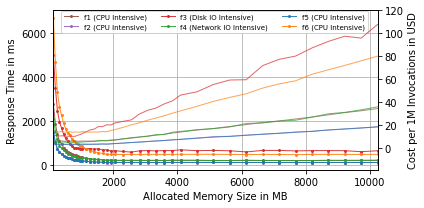

In [38]:
fig=plt.figure(figsize=(6, 3))
ax=plt.subplot(111)
ax.grid()
ax.set_xlim(128, 10240)
ax2 = ax.twinx()
ax2.set_ylim(-19, 120)

ax.plot(viable_mem_list, f1_duration, marker='o', label='f1 (CPU Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:brown') 
ax.plot(viable_mem_list, f2_duration, marker='o', label='f2 (CPU Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:purple') 
ax.plot(viable_mem_list, f3_duration, marker='o', label='f3 (Disk IO Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:red')
ax.plot(viable_mem_list, f4_duration, marker='o', label='f4 (Network IO Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:green')
ax.plot(viable_mem_list, f5_duration, marker='o', label='f5 (CPU Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:blue')
ax.plot(viable_mem_list, f6_duration, marker='o', label='f6 (CPU Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:orange')

ax2.plot(viable_mem_list, f1_cost, marker='+', label='f1 (CPU Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:brown') 
ax2.plot(viable_mem_list, f2_cost, marker='+', label='f2 (CPU Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:purple') 
ax2.plot(viable_mem_list, f3_cost, marker='+', label='f3 (Disk IO Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:red')
ax2.plot(viable_mem_list, f4_cost, marker='+', label='f4 (Network IO Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:green')
ax2.plot(viable_mem_list, f5_cost, marker='+', label='f5 (CPU Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:blue')
ax2.plot(viable_mem_list, f6_cost, marker='+', label='f6 (CPU Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:orange')

ax.legend(loc='upper right',  bbox_to_anchor=(0.98, 1.02), prop={'size': 7}, ncol=3)

ax.set_xlabel('Allocated Memory Size in MB')
ax.set_ylabel('Response Time in ms')
ax2.set_ylabel('Cost per 1M Invocations in USD')
fig.tight_layout()
fig.savefig('OptAlg_Performance_Curve', dpi=300)
fig.savefig('OptAlg_Performance_Curve.pdf')

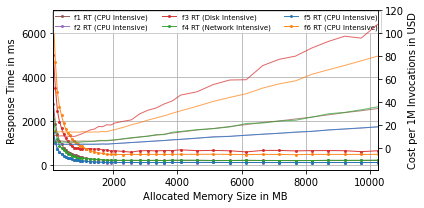

In [54]:
fig=plt.figure(figsize=(6, 3))
ax=plt.subplot(111)
ax.grid()
ax.set_xlim(128, 10240)
ax2 = ax.twinx()
ax2.set_ylim(-19, 120)

ax.plot(viable_mem_list, f1_duration, marker='o', label='f1 RT (CPU Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:brown') 
ax.plot(viable_mem_list, f2_duration, marker='o', label='f2 RT (CPU Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:purple') 
ax.plot(viable_mem_list, f3_duration, marker='o', label='f3 RT (Disk Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:red')
ax.plot(viable_mem_list, f4_duration, marker='o', label='f4 RT (Network Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:green')
ax.plot(viable_mem_list, f5_duration, marker='o', label='f5 RT (CPU Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:blue')
ax.plot(viable_mem_list, f6_duration, marker='o', label='f6 RT (CPU Intensive)', linewidth=1, markersize=2, alpha=0.9, color='tab:orange')

ax2.plot(viable_mem_list, f1_cost, marker='+', label='f1 (CPU Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:brown') 
ax2.plot(viable_mem_list, f2_cost, marker='+', label='f2 (CPU Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:purple') 
ax2.plot(viable_mem_list, f3_cost, marker='+', label='f3 (Disk IO Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:red')
ax2.plot(viable_mem_list, f4_cost, marker='+', label='f4 (Network IO Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:green')
ax2.plot(viable_mem_list, f5_cost, marker='+', label='f5 (CPU Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:blue')
ax2.plot(viable_mem_list, f6_cost, marker='+', label='f6 (CPU Intensive)', linewidth=1, markersize=0, alpha=0.7, color='tab:orange')

ax.legend(loc='upper right',  bbox_to_anchor=(1.02, 1.02), prop={'size': 7}, ncol=3)

ax.set_xlabel('Allocated Memory Size in MB')
ax.set_ylabel('Response Time in ms')
ax2.set_ylabel('Cost per 1M Invocations in USD')
fig.tight_layout()
fig.savefig('OptAlg_Performance_Curve', dpi=300)
fig.savefig('OptAlg_Performance_Curve.pdf')

In [200]:
viable_mem_list[f6_duration.index(min(f6_duration))]

7680

In [204]:
f6_duration[viable_mem_list.index(128)]

6722.771949999999

In [205]:
f6_duration[viable_mem_list.index(576)]

1444.7904499999997

In [203]:
f6_duration[viable_mem_list.index(1280)]

651.75345

In [207]:
min(f6_cost)

13.749433348812499

In [210]:
viable_mem_list[f6_cost.index(min(f6_cost))]

576

In [213]:
viable_mem_list.index(576)

7

In [214]:
f6_duration[7]

1444.7904499999997

In [22]:
perf_cost_list = pd.DataFrame(columns=['mem', 'rt', 'cost', 'bcr'])

In [314]:
perf_cost_list['mem'] = viable_mem_list

In [315]:
perf_cost_list['rt'] = f2_duration

In [316]:
perf_cost_list['cost'] = f2_cost

In [21]:
for index, row in perf_cost_list.iterrows():
    drt = row['rt'] -  238.547350
    dcost = row['cost'] - 3.188256
    if dcost != 0:
        perf_cost_list.loc[index, 'bcr'] = drt/dcost

NameError: name 'perf_cost_list' is not defined

In [318]:
perf_cost_list

,mem,rt,cost,bcr
0,128,1501.711407,3.329581,8937.9948
1,192,995.206900,3.311631,6132.994373
2,256,724.672100,3.221485,14629.440648
3,320,582.490200,3.236464,7134.499494
4,384,498.490200,3.318631,1993.805384
5,448,428.678250,3.329407,1347.000696
6,512,359.499800,3.199714,10555.850719
7,576,322.456150,3.227990,2111.740321
8,640,298.465750,3.314225,475.659966
9,704,269.975600,3.299313,282.990818


In [361]:
perf_cost_list = pd.DataFrame(columns=['mem', 'rt', 'cost', 'bcr'])
perf_cost_list['mem'] = viable_mem_list
perf_cost_list['rt'] = f3_duration
perf_cost_list['cost'] = f3_cost
for index, row in perf_cost_list.iterrows():
    drt = 6722.77195 - row['rt']
    dcost = 14.206778 - row['cost']
    if dcost != 0:
        perf_cost_list.loc[index, 'bcr'] = drt/dcost

In [362]:
perf_cost_list

,mem,rt,cost,bcr
0,128,5031.42135,10.683177,480.006307
1,192,3510.56580,11.172178,1058.527106
2,256,2468.46455,10.487479,1143.846541
3,320,1980.34025,10.516922,1285.261886
4,384,1670.77040,10.645521,1418.600622
5,448,1410.59845,10.489036,1428.871016
6,512,1215.07095,10.329770,1420.60614
7,576,1072.83710,10.262630,1432.485326
8,640,972.66660,10.336947,1485.88036
9,704,873.32400,10.212770,1464.555902


In [326]:
OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f2'", 2304))['Duration'].mean()

107.7659

In [305]:
np.percentile(OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f2'", 2304))['Duration'], 90)

109.25

In [311]:
OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f2'", 6656))['Duration'].mean()

107.87485000000001

In [312]:
np.percentile(OptAlg_lambda_logs.query("Function == {} and Memory_Size == {}".format("'f2'", 6656))['Duration'], 90)

109.062

In [23]:
perf_cost_list = pd.DataFrame(columns=['mem', 'rt', 'cost', 'bcr'])
perf_cost_list['mem'] = viable_mem_list
perf_cost_list['rt'] = f6_duration
perf_cost_list['cost'] = f6_cost
for index, row in perf_cost_list.iterrows():
    drt = row['rt'] - 1444.79045
    dcost = row['cost'] - 13.749433
    if dcost != 0:
        perf_cost_list.loc[index, 'bcr'] = drt/dcost
perf_cost_list

,mem,rt,cost,bcr
0,128,6722.77195,14.206778,11540.481134
1,192,4699.89510,14.888717,2857.149754
2,256,3309.16915,13.990361,7738.32583
3,320,2650.43205,14.007033,4680.288942
4,384,2261.40455,14.336841,1390.199682
5,448,1898.69895,14.048215,1519.195272
6,512,1653.64320,13.984486,888.535083
7,576,1444.79045,13.749433,-0.000001
8,640,1347.83700,14.244872,-195.692066
9,704,1188.82090,13.827710,-3270.066958


In [31]:
perf_cost_list = pd.DataFrame(columns=['mem', 'rt', 'cost', 'bcr'])
perf_cost_list['mem'] = viable_mem_list
perf_cost_list['rt'] = f6_duration
perf_cost_list['cost'] = f6_cost
for index, row in perf_cost_list.iterrows():
    drt = 6722.77195 - row['rt']
    dcost = 14.206778- row['cost']
    if dcost != 0:
        perf_cost_list.loc[index, 'bcr'] = drt/dcost
perf_cost_list

,mem,rt,cost,bcr
0,128,6722.77195,14.206778,-0.000067
1,192,4699.89510,14.888717,-2966.360941
2,256,3309.16915,13.990361,15773.259233
3,320,2650.43205,14.007033,20387.675676
4,384,2261.40455,14.336841,-34301.647394
5,448,1898.69895,14.048215,30423.736776
6,512,1653.64320,13.984486,22803.908917
7,576,1444.79045,13.749433,11540.490276
8,640,1347.83700,14.244872,-141097.221863
9,704,1188.82090,13.827710,14598.817197
